#Song recommender by Pieter

In [1]:
import sframe as sf
import numpy as np

In [346]:
import gc
gc.collect()

0

##Carregando dados

In [3]:
song_data = sf.SFrame('song_data.gl/')

2016-04-22 15:54:41,178 [INFO] sframe.cython.cy_server, 172: SFrame v1.8.5 started. Logging C:\Users\PIETER~1.VOL\AppData\Local\Temp\sframe_server_1461351280.log.0


##Explorando os dados

In [4]:
song_data.head()

user_id,song_id,listen_count,title,artist
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOAKIMP12A8C130995,1,The Cove,Jack Johnson
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOBXHDL12A81C204C0,1,Stronger,Kanye West
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N'Roll ...,Héroes del Silencio
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SODXRTY12AB0180F3B,1,Paper Gangsta,Lady GaGa
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOFGUAY12AB017B0A8,1,Stacked Actors,Foo Fighters
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOFRQTD12A81C233C0,1,Sehr kosmisch,Harmonia
b80344d063b5ccb3212f76538f3d9e43d87dca9e ...,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn youreyes ...,Thievery Corporationfeat. Emiliana Torrini ...


###Mostrando as músicas mais populares

In [5]:
song_data.groupby(key_columns='song', operations={'count': sf.aggregate.COUNT()}).sort('count', ascending=False)

song,count
Sehr kosmisch - Harmonia,5970
Undo - Björk,5281
You're The One - DwightYoakam ...,4806
Dog Days Are Over (RadioEdit) - Florence + The ...,4536
Revelry - Kings Of Leon,4339
Horn Concerto No. 4 in Eflat K495: II. Romance ...,3949
Secrets - OneRepublic,3916
Tive Sim - Cartola,3185
Fireflies - CharttraxxKaraoke ...,3171
Hey_ Soul Sister - Train,3132


In [6]:
len(song_data)

1116609

###Contando usuários únicos

In [7]:
users = song_data['user_id'].unique()

In [8]:
len(users)

66346

##Criando modelos de recomendação

In [9]:
train_data, test_data = song_data.random_split(.8, seed=0)

###Classe abstrata para os modelos

In [236]:
from time import clock
import sys
import gc

class BaseRecommender():
    '''
    Classe base para os recomendadores criados.
    '''
    
    def __init__(self, name, observation_data, user_id='user_id', item_id='item_id', target=None, verbose=False): 
        '''
        Construtor da objeto base.
        
        Parâmetros:
        -----------
        name: Nome do modelo. Serve apenas para mostrar o tipo de modelo durante a inicialização.
        
        observation_data: SFrame contendo os dados aos quais queremos avaliar.
        
        user_id: Coluna da base contendo os dados de usuários.
        
        item_id: Coluna da base contendo os dados de itens.
        
        target: Coluna da base contendo os dados de scores.
        
        verbose: Indica se o progresso de criação ou utilização deverá ser apresentado.
        '''        
        self.model_name = name
        self.observation_data = observation_data
        self.user_id = user_id
        self.item_id = item_id
        self.target = target
        self.verbose = verbose
        gc.collect()
        
        # Se verbose for true, vou criar uma função global para apresentar as mensagens.
        # Muito melhor do que a todo momento ficar fazendo if verbose: print 'bla bla bla'
        if verbose:
            def _v_print(*objects):
                if self.verbose: 
                    print objects[0]
                    # Esse comando serve para liberar todo o buffer do texto. Sem isso, a impressão às vezes
                    # não sai no momento em que se espera.
                    sys.stdout.flush()
        else:
            _v_print = lambda *o: None
            
        global v_print 
        v_print = _v_print                    
        
    def _summary_initialization(self, elapsed_time):
        '''
        Apresenta um sumário da inicialização.
        
        Parâmetros:
        -----------
        elapsed_time: Tempo decorrido da inicialização.
        '''        
        v_print('Recommender system: model = %s' % (self.model_name))
        # Assim como o Graphlab, apresento quais colunas não foram utilizadas
        columns_diff = np.setdiff1d(self.observation_data.column_names(), [self.user_id, self.item_id])
        if len(columns_diff) > 0:
            v_print('\nWarning: ignoring columns %s;' % (', '.join(columns_diff)))
        v_print('\nPreparing data set.')
        v_print('\n\tData has %s observations with %s users and %s items.' % \
                (len(self.observation_data), 
                 len(np.unique(list(self.observation_data[self.user_id]))),
                 len(np.unique(list(self.observation_data[self.item_id])))))
        v_print('\n\tData prepared in: %ss' % (elapsed_time))
    
    def recommend(self, users, k=10):
        '''
        Identifica recomendações de itens para os usuários passados.
        
        Parâmetros:
        -----------
        users: Lista com os usuários aos quais se deseja recomendar algo.
        
        k: Total de itens recomendados.
        
        Retorno:
        --------
        SFrame contendo as recomendações, no mesmo estilo do Graphlab.
        '''
        raise NotImplementedError("cannot instantiate Abstract Base Class")
        
    def get_similar_items(self, items, k=10):
        '''
        Identifica itens similares.
        
        Parâmetros:
        -----------
        items: Lista com os itens que se deseja verificar similaridades.
        
        k: Total de similaridades desejadas para cada item.
        
        Retorno:
        --------
        SFrame contendo os itens similares, no mesmo estilo do Graphlab.
        '''
        raise NotImplementedError("cannot instantiate Abstract Base Class")

###Classe para o modelo de recomendação por popularidade

In [237]:
class PopularityRecommender(BaseRecommender):
    '''
    Recomendador baseado em popularidade.
    '''
    
    def __init__(self, observation_data, user_id='user_id', item_id='item_id', target=None, verbose=False):
        '''
        Construtor do recomendador.
        
        Parâmetros:
        -----------
        observation_data: SFrame contendo os dados aos quais queremos avaliar.
        
        user_id: Coluna da base contendo os dados de usuários.
        
        item_id: Coluna da base contendo os dados de itens.
        
        target: Coluna da base contendo os dados de scores.
        
        verbose: Indica se o progresso de criação ou utilização deverá ser apresentado.
        '''  
        BaseRecommender.__init__(self, 'popularity', observation_data, user_id, item_id, target, verbose)
        
        start = clock()
        self._fit()
        elapsed_time = clock() - start
        
        self._summary_initialization(elapsed_time)
        
    def recommend(self, users, k=10):
        '''
        Identifica recomendações de itens para os usuários passados.
        
        Parâmetros:
        -----------
        users: Lista com os usuários aos quais se deseja recomendar algo.
        
        k: Total de itens recomendados.
        
        Retorno:
        --------
        SFrame contendo as recomendações, no mesmo estilo do Graphlab.
        
        TODO:
        -----
        Por enquanto esse método só está trazendo as recomendações para um único usuário, por mais 
        que passe mais usuários no parâmetro users.
        Acredito que da forma que está (usando os métodos do SFrame), não seja muito performático.
        '''
        # Filtra todos os itens do usuário
        all_items = self.observation_data[self.observation_data[self.user_id] == users[0]][self.item_id]
        # Remove itens duplicados, caso haja
        all_items = np.unique(all_items)
        # Da base de popularidade, retorna todas as músicas que ele não ouviu
        return self.popularity_data.filter_by(all_items, column_name=self.item_id, exclude=True).head(10)
    
    def get_similar_items(self, items, k=10):
        '''
        Identifica itens similares.
        
        Parâmetros:
        -----------
        items: Lista com os itens que se deseja verificar similaridades.
        
        k: Total de similaridades desejadas para cada item.
        
        Retorno:
        --------
        SFrame contendo os itens similares, no mesmo estilo do Graphlab.
        
        TODO:
        -----
        Ainda não implementei esse método. Não sei nem se seria necessário, pois não vejo muita
        utilidade em verificar similaridades de itens em um modelo baseado em popularidade.
        '''
        raise NotImplementedError("cannot instantiate Abstract Base Class")
    
    def _fit(self):
        '''
        Cria a base de popularidade.
        
        Retorno:
        --------
        Não retorna nada. Apenas cria um novo atributo na classe.
        
        TODO:
        -----
        Ao invés de criar um atributo por aqui, melhor deixar esse método retornar algo e inicializar
        todos os atributos no construtor.
        Falta testar o recomendador por score.
        '''
        if self.target is None:
            # Se não foi passado score para olharmos, fazemos apenas o groupby com o método count
            self.popularity_data = self.observation_data.groupby(key_columns=self.item_id, 
                                                                 operations={'score': sf.aggregate.COUNT()})
        else:
            # Agora... se foi passado score para olharmos, fazemos o groupby com o método sum do score
            self.popularity_data = self.observation_data.groupby(key_columns=self.item_id, 
                                                                 operations={'score': sf.aggregate.SUM(self.target)})
        
        # Ordena a base de acordo com o score que calculamos em ordem decrescente
        self.popularity_data = self.popularity_data.sort('score', ascending=False)

In [238]:
popularity_model = PopularityRecommender(train_data,
                                         user_id='user_id',
                                         item_id='song',
                                         verbose=True)

Recommender system: model = popularity


Preparing data set.

	Data has 893580 observations with 66085 users and 9952 items.

	Data prepared in: 0.612356888108s


###Previsões com modelo de recomendação por popularidade

In [93]:
popularity_model.recommend(users=[users[0]])

song,score
Sehr kosmisch - Harmonia,4754
Undo - Björk,4227
You're The One - DwightYoakam ...,3781
Dog Days Are Over (RadioEdit) - Florence + The ...,3633
Revelry - Kings Of Leon,3527
Horn Concerto No. 4 in Eflat K495: II. Romance ...,3161
Secrets - OneRepublic,3148
Fireflies - CharttraxxKaraoke ...,2532
Tive Sim - Cartola,2521
Drop The World - LilWayne / Eminem ...,2053


In [94]:
popularity_model.recommend(users=[users[1]])

song,score
Sehr kosmisch - Harmonia,4754
Undo - Björk,4227
You're The One - DwightYoakam ...,3781
Dog Days Are Over (RadioEdit) - Florence + The ...,3633
Revelry - Kings Of Leon,3527
Horn Concerto No. 4 in Eflat K495: II. Romance ...,3161
Secrets - OneRepublic,3148
Hey_ Soul Sister - Train,2538
Fireflies - CharttraxxKaraoke ...,2532
Tive Sim - Cartola,2521


###Classe para o modelo de recomendação por personalidade

In [494]:
# Usamos o LabelEncoder para codificar os itens e usuários
from sklearn.preprocessing import LabelEncoder

# Usamos sparse matrices para economizar espaço na memória
from scipy.sparse import coo_matrix, lil_matrix, dok_matrix, find
import scipy.spatial.distance as ssd

import operator
import math

class ItemSimilarityRecommender(BaseRecommender):
    '''
    Recomendador baseado em similaridade de itens.
    '''
    
    def __init__(self, observation_data, user_id='user_id', item_id='item_id', target=None, verbose=False, 
                 metric='jaccard', threshold=0.001):
        '''
        Construtor do recomendador.
        
        Parâmetros:
        -----------
        observation_data: SFrame contendo os dados aos quais queremos avaliar.
        
        user_id: Coluna da base contendo os dados de usuários.
        
        item_id: Coluna da base contendo os dados de itens.
        
        target: Coluna da base contendo os dados de scores.
        
        verbose: Indica se o progresso de criação ou utilização deverá ser apresentado.
        
        metric: Métrica a ser usada para comparar 2 itens.
        
        threshold: Valor mínimo de similaridade. Abaixo disso, consideramos zero.
        
        TODO:
        -----
        - Implementar a passagem do parâmetro target para avaliar o score.
        - Implementar novas métricas, como cosine e pearson. Atualmente só jaccard é usada.
        - Implementar detecção de onde armazenar a matrix item-item, se memória ou SFrame, assim como no Graphlab.
        - Implementar parâmetro para deixar somente os itens com mais relevância na matrix item-item.
        - Fazer estudos com o uso de GPU para acelerar os cálculos, principalmente de métricas.
        ''' 
        BaseRecommender.__init__(self, 'item similarity', observation_data, user_id, item_id, target, verbose)
        self.metric = metric
        self.threshold = threshold
        
        self._summary_initialization(0.)
        
        v_print('\nPreparing label encoders for users and items.')
        start = clock()
        # Codifica usuários (W) e itens (H)
        self.W, self.H, self.Wenc, self.Henc = self._create_encoders()
        elapsed_time = clock() - start
        v_print('\n\tEncoders created in: %ss' % (elapsed_time))
        
        v_print('\nPreparing co-occurence matrix.')
        start = clock()
        #self.csr, self.csc, self.idf = self._factorize(self.W, self.H)
        # Cria matriz de co-ocorrência para usuários e itens
        self.csr, self.csc = self._factorize(self.W, self.H)
        elapsed_time = clock() - start
        v_print('\n\tCo-occurence matrix created (shape=[%s, %s]) in: %ss' % (self.csr.shape[0], self.csr.shape[1], elapsed_time))
            
        v_print('\nPreparing item-item symmetric matrix.')
        start = clock()
        if len(self.Henc.classes_) < 20000:
            # Cria matriz simétrica item-item
            self.HxH = self._create_item_by_item_matrix(self.H, metric=metric)
        elapsed_time = clock() - start
        v_print('\n\tItem-item symmetric matrix created in: %ss' % (elapsed_time))
                
    def _create_encoders(self):
        '''
        Internamente não utilizamos strings para descrever usuários ou itens. Por isso a codificação deles.
        
        Retorno:
        --------
        W: Usuários codificados
        
        H: Itens codificados
        
        Wenc: Codificador dos usuários, para poder fazer novas codificações ou para fazer a transformação inversa
        
        Henc: Codificador dos itens, para poder fazer novas codificações ou para fazer a transformação inversa
        '''
        Wenc = LabelEncoder()
        Henc = LabelEncoder()
        
        # Codificando usuários e itens
        W = Wenc.fit_transform(list(self.observation_data[self.user_id]))
        H = Henc.fit_transform(list(self.observation_data[self.item_id]))
        
        return W, H, Wenc, Henc
    
    def _reduce_dataset(self, dataset):
        '''
        Método para reduzir um dataset de entrada para um que só tenha os usuários ou itens codificados.
        Isso evita problemas quando não temos informações de um usuário ou item.
        
        Parâmetros:
        -----------
        dataset: Base ao qual se quer avaliar.
        
        Retorno:
        --------
        Dataset reduzido com somente usuários e itens codificados.
        '''
        # Pego usuários e itens codificados
        Wclasses = list(self.Wenc.classes_)
        Hclasses = list(self.Henc.classes_)
        
        # Reduzo usuários ainda não codificados da base de entrada
        reduced_dataset = dataset.filter_by(Wclasses, self.user_id)
        # Reduzo itens ainda não codificados da base de entrada
        reduced_dataset = reduced_data.filter_by(Hclasses, self.item_id)
        
        return reduced_dataset
    
    def _encode_dataset(self, dataset):
        '''
        Método interno para codificar um dataset.
        
        Parâmetros:
        -----------
        dataset: Base ao qual se quer avaliar.
        
        Retorno:
        --------
        W: Usuários dessa base codificados.
        
        H: Itens dessa base codificados.
        '''
        # Reduzimos o dataset com somente os usuários e itens codificados no construtor da classe
        reduced_dataset = self._reduce_dataset(dataset)
        
        # Codificamos os usuários e itens
        W = self.Wenc.transform(list(reduced_dataset[self.user_id]))
        H = self.Henc.transform(list(reduced_dataset[self.item_id]))
        
        return W, H
    
    def _factorize(self, W, H):
        '''
        Método para criar a matrix de co-ocorrência entre usuários e itens.
        
        Parâmetros:
        -----------
        W: Usuários codificados.
        
        H: Itens codificados.
        
        Retorno:
        --------
        csr: Sparse matrix da matriz de co-ocorrência para busca rápida em linha. 
        
        csc: Sparse matrix da matriz de co-ocorrência para busca rápida em coluna.
        
        TODO:
        -----
        Avaliar a performance de usar uma sparse matrix do tipo lil_matrix ao invés de termos 2 sparse matrices.
        '''
        #grouped_data = sf.SFrame({self.item_id: H})
        #grouped_data = grouped_data.groupby(key_columns=self.item_id, 
        #                                    operations={'count': sf.aggregate.COUNT()}).sort('count', ascending=False)
        #
        #item_id_arr = np.asarray(grouped_data[self.item_id])
        #count_arr = np.asarray(grouped_data['count'])
        
        # Distinct nos usuários e itens codificados
        Wunique = np.unique(W)
        Hunique = np.unique(H)
        
        #idf = {}
        #N = len(Wunique)
        #for i in xrange(len(item_id_arr)):
        #    idf[item_id_arr[i]] = math.log(N / (1. + float(count_arr[i])))
            
        #V = np.zeros(shape=(len(Wunique), len(Hunique)))
        #for r in zip(W, H):
        #    V[r[0], r[1]] = 1. #idf[r[1]]
        
        # Criamos uma lil_matrix (tem performance boa para acesso por linha ou coluna) com o valor máximo de cada dimensão
        V = lil_matrix((max(Wunique) + 1, max(Hunique) + 1))
        # Associamos o valor 1 (hum) para cada ocorrência
        for i, j in zip(W, H):
            V[i, j] = 1.
            
        #V = coo_matrix(V)
        
        # Convertemos para as matrizes de busca rápida em linha e coluna
        csr = V.tocsr()
        csc = V.tocsc()
            
        return csr, csc #, idf
    
    def _compute_similarity(self, A, B, metric='jaccard'):
        '''
        Método para calcular similaridade entre 2 conjuntos.
        
        Parâmetros:
        -----------
        A: Lista A
        
        B: Lista B
        
        metric: Tipo de métrica a ser utilizada.
        
        Retorno:
        --------
        Similaridade entre 2 listas.
        
        TODO:
        -----
        - Implementar novas métricas, como cosine e pearson.
        - Adotar o uso de GPU
        '''
        return self._fast_compute_similarity(set(A), set(B))
        
    def _fast_compute_similarity(self, setA, setB, threshold=0.001):
        '''
        Método mais rápido para calcular similaridade entre 2 conjuntos.
        
        Parâmetros:
        -----------
        A: Objeto do tipo 'set' para o conjunto A
        
        B: Objeto do tipo 'set' para o conjunto B
        
        threshold: Limite de similaridade. Abaixo disso é zero.
        
        Retorno:
        --------
        Similaridade entre 2 listas usando método jaccard.
        
        TODO:
        -----
        - Adotar o uso de GPU
        '''
        n = len(setA.intersection(setB))
        s = n / float(len(setA) + len(setB) - n)
        return s if s > threshold else 0.
    
    def _create_item_by_item_matrix(self, m, metric='jaccard'):
        '''
        Método para a criação da matriz simétrica item-item contendo a similaridade entre cada item.
        
        A similaridade entre 2 itens é dada pela comparação entre os seus usuários.
        
        Parâmetros:
        -----------
        m: Lista contendo os itens codificados.
        
        metric: Métrica a ser usada para o cálculo das similaridades.
        
        Retorno:
        --------
        Matriz item-item contendo todas as similaridades.
        
        TODO:
        -----
        - Implementar novas métricas, como cosine e pearson.
        - Identificar se guardaremos em memória ou em um SFrame.
        - Adotar o uso de GPU
        '''
        # Removemos itens duplicados
        mu = np.unique(m)
        # Criamos matriz do tipo lil_matrix para acesso bom tanto por linha como por coluna
        mxm = lil_matrix((len(mu), len(mu)))
        csc = self.csc
        
        # Criamos um dicionário que guardará em objetos do tipo 'set' os índices de todos os usuários para cada item
        indices = {}
        for i in xrange(len(mu)):
            indices[i] = set(csc[:, i].indices)
        
        v_print('')
        v_print('+-----------------+-----------------+')
        v_print('| Number of items | Elapsed Time    |')
        v_print('+-----------------+-----------------+')
        
        start = clock()
        # Laço principal. Aqui iremos preencher metade da matriz (um triângulo), pois ela é simétrica
        for i in xrange(0, len(mu)):
            # Armazenamos os índices de usuários do item atual do laço (para não ter que ficar acessando o dicionário todo tempo)
            current_indices = indices[i]
            # Calculamos as similaridades do item atual com todos os demais.
            mxm[i, i:] = [self._fast_compute_similarity(current_indices, indices[j]) for j in xrange(i, len(mu))]
            # A cada 1000 itens analizados, soltamos uma mensagem de progresso.
            if (i + 1) % 1000 == 0:
                elapsed_time = clock() - start
                v_print('| %s | %s |' % (str(i + 1).ljust(15), (str(elapsed_time) + 's').ljust(15)))
                start = clock()
        
        v_print('+-----------------+-----------------+')
        
        # Bem, como preenchemos apenas metade da matriz, aqui vem um truque. Como a matriz deve ser simétrica,
        # somamos ela com a transposta dela mesma.
        mxm = mxm + mxm.T
        
        # ... Entretanto, a idenficade da matriz fica dobrada, por isso, voltamos a 1
        for i in xrange(0, len(mu)):
            mxm[i, i] = 1.
        
        return mxm
    
    def _build_recommender_sframe(self, first_column_name, recommend_column_name, recommendations):
        '''
        Método para facilitar a criação do SFrame de retorno dos métodos de recomendação ou similaridade de itens.
        
        Parâmetros:
        -----------
        first_column_name: Nome da primeira coluna (user_id ou item_id no caso)
        
        recommend_column_name: Nome da coluna que trará as recomendações (item_id ou similar no caso)
        
        recommendations: Lista com as recomendações.
        
        Retorno:
        --------
        SFrame apresentando as recomendações.
        '''
        rec_frame = sf.SFrame()
        rec_frame[first_column_name] = [item[2] for i, item in enumerate(recommendations)]
        rec_frame[recommend_column_name] = [self.Henc.inverse_transform(item[1]) for i, item in enumerate(recommendations)]
        rec_frame['score'] = [item[0] for i, item in enumerate(recommendations)]
        rec_frame['rank'] = [i + 1 for i, item in enumerate(recommendations)]
        return rec_frame
    
    def _get_users_recommendations(self, users, k=10, only_indices=False, exclude_known=True):
        '''
        Método interno para identificar recomendações de itens para uma lista de usuários.
        
        Parâmetros:
        -----------
        users: Lista com usuários aos quais se deseja recomendar algo.
        
        k: Número máximo de recomendações.
        
        only_indices: True para retornar apenas os índices das recomendações (facilita na avaliação do recomendador).
        
        exclude_known: True para excluir os itens que o próprio usuário possui.
        
        Retorno:
        --------
        Lista com as recomendações para cada usuário. 
        
        Cada recomendação estará no formato (score, índice, usuário). Salvo quando only_indices estiver como True que,
        no caso, será retornado apenas os índices.
        '''
        # Aqui é um pequeno truque. Caso a entrada não seja do tipo 'list', convertemos para 'list'. Isso evita problemas
        # quando se passam outros tipos de objetos. O SFrame, por exemplo, é muito lento quando entra em um laço.
        if type(users) is not list: users = list(users)
        total_users = len(users)
        
        sub_start = clock()
        
        recommendations = []
        # Laço para percorrer cada usuário informado
        for u in xrange(total_users):
            # Armazena o usuário atual (para evitar ter que acessar o vetor a todo instante)
            enc_user = users[u]
            # Como está codificado, faz um de-para para o usuário normal, pois será ele quem retornaremos no final
            user = self.Wenc.inverse_transform(enc_user)
            # Identifica os itens deste usuário
            item_list = self.csr[enc_user].indices         
            
            # Laço para ir somando todos os itens similares a estes do usuário
            # Provavelmente o Graphlab deve ter algo diferente aqui, pois o score é diferente do meu, apesar do 
            # resultado parecido.
            results = self.HxH[item_list[0]]
            for i in xrange(1, len(item_list)):
                results = results + self.HxH[item_list[i]]
            
            # Zipa tudo no formato (score, índice, usuário)
            zipped = zip(results.data, 
                         results.indices,
                         [user for i in xrange(len(results.data))])
            
            # Exclui todos os itens que o usuário possui para evitar recomendar o mesmo.
            if exclude_known:
                zipped = [(a, b, c) for a, b, c in zipped if b not in item_list]
            
            # Se for só um item a ser recomendado, ao invés de ordenar e pegar o primeiro, mais fácil retornar o de
            # maior score.
            if k == 1:
                recommendations.extend([max(zipped)])
            else:
                recommendations.extend(sorted(zipped, reverse=True)[:k])
            
            # A cada 1000 usuários, apresenta progresso.
            if (u + 1) % 1000 == 0:
                v_print('recommendations finished on %s/%s queries. users per second: %s\n' % \
                        (u + 1, total_users, 1000. / (clock() - sub_start)))
                sub_start = clock()
        
        # Retorna no formato desejado
        return [i for d, i, u in recommendations] if only_indices else recommendations
    
    def _get_items_recommendations(self, items, k=10, only_indices=False, exclude_known=True):
        '''
        Método interno para identificar similaridades entre itens e os recomendar.
        
        Parâmetros:
        -----------
        items: Lista com itens aos quais se deseja ter recomendações de outros itens similares.
        
        k: Número máximo de recomendações.
        
        only_indices: True para retornar apenas os índices das recomendações (facilita na avaliação do recomendador).
        
        exclude_known: True para excluir o próprio item.
        
        Retorno:
        --------
        Lista com recomendações para cada item.
        
        Cada recomendação estará no formato (score, índice, item). Salvo quando only_indices estiver como True que,
        no caso, será retornado apenas os índices.
        '''
        # Aqui é um pequeno truque. Caso a entrada não seja do tipo 'list', convertemos para 'list'. Isso evita problemas
        # quando se passam outros tipos de objetos. O SFrame, por exemplo, é muito lento quando entra em um laço.
        if type(items) is not list: items = list(items)
        total_items = len(items)
        
        sub_start = clock()
                                       
        recommendations = [] 
        # Laço para percorrer cada item informado
        for i in xrange(total_items):
            # Armazena o item atual (para evitar ter que acessar o vetor a todo instante)
            enc_item = items[i]
            # Como está codificado, faz um de-para para o item normal, pois será ele quem retornaremos no final
            item = self.Henc.inverse_transform(enc_item)
            # Identifica as similaridades com os demais itens
            results = self.HxH[enc_item]
            
            # Zipa tudo no formato (score, índice, item)
            zipped = zip(results.data, 
                         results.indices,
                         [item for r in xrange(len(results.data))])
            
            # Exclui os próprios itens
            if exclude_known:
                zipped = [(a, b, c) for a, b, c in zipped if b != enc_item]
            
            # Se for só um item a ser recomendado, ao invés de ordenar e pegar o primeiro, mais fácil retornar o de
            # maior score.
            if k == 1:
                recommendations.extend([max(zipped)])
            else:
                recommendations.extend(sorted(zipped, reverse=True)[:k])
            
            # A cada 1000 itens, apresenta progresso.
            if (i + 1) % 1000 == 0:
                v_print('recommendations finished on %s/%s queries. items per second: %s\n' % \
                        (i + 1, total_items, 1000. / (clock() - sub_start)))
                sub_start = clock()
                
        return [i for d, i, item in recommendations] if only_indices else recommendations
    
    def recommend(self, users, k=10):
        '''
        Identifica recomendações de itens para os usuários passados.
        
        Parâmetros:
        -----------
        users: Lista com os usuários aos quais se deseja recomendar algo.
        
        k: Total de itens recomendados.
        
        Retorno:
        --------
        SFrame contendo as recomendações, no mesmo estilo do Graphlab.
        '''
        start = clock()
        # Antes de sair procurando recomendações, filtramos os usuários que não estão codificados
        filtered_users = np.intersect1d(users, self.Wenc.classes_)
        # Identifica as recomendações
        recommendations = self._get_users_recommendations(self.Wenc.transform(filtered_users), k)        
        v_print('Getting recommended items in %ss.' % (clock() - start))
        
        # Retorna de um jeito similar ao do Graphlab
        return self._build_recommender_sframe(self.user_id, self.item_id, recommendations)
        
    def get_similar_items(self, items, k=10):
        '''
        Identifica itens similares.
        
        Parâmetros:
        -----------
        items: Lista com os itens que se deseja verificar similaridades.
        
        k: Total de similaridades desejadas para cada item.
        
        Retorno:
        --------
        SFrame contendo os itens similares, no mesmo estilo do Graphlab.
        '''
        start = clock()
        # Antes de sair procurando recomendações, filtramos os itens que não estão codificados
        filtered_items = np.intersect1d(items, self.Henc.classes_)
        # Identifica as recomendações
        recommendations = self._get_items_recommendations(self.Henc.transform(filtered_items), k) 
        v_print('Getting similar items in %ss.' % (clock() - start))
        
        # Retorna de um jeito similar ao do Graphlab
        return self._build_recommender_sframe(self.item_id, 'similar', recommendations)
    
    def _precision_recall(self, predicted_indices, real_indices):
        '''
        Método para calcular precision e recall.
        
        Parâmetros:
        -----------
        predicted_indices: Índices das recomendações feitas pelo modelo.
        
        real_indices: Índices reais da base de teste ou treino.
        
        Retorno:
        --------
        precision: (#Liked AND #Shown) / #Shown
        
        recall: (#Liked AND #Shown) / #Liked
        '''
        # Converte para objetos do tipo 'set'
        setP = set(predicted_indices)
        setR = set(real_indices)
        
        # Calcula precision e recall
        n = len(setR.intersection(setP))
        recall = n / float(len(setR)) if len(setR) else 0.
        precision = n / float(len(setP)) if len(setP) else 0.
        
        return precision, recall
    
    def evaluate(self, dataset, cutoffs=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16, 21, 26, 31, 36, 41, 46], user_sample=.05):
        '''
        Método para avaliação do recomendador.
        
        Parâmetros:
        -----------
        dataset: Base de dados ao qual se deseja avaliar o recomendador.
        
        cutoffs: Quais serão os k's a serem passados nos métodos de recomendação.
        
        user_sample: Quando passado um valor do tipo 'float', será o percentual da amostragem a ser analisada, 
            quando 'int', o número absoluto da amostragem.
            
        Retorno:
        --------
        SFrame contendo os resultados da avaliação.
        
        TODO:
        -----
        - Verificar o que é mais performático, fazer um laço de cutoffs e depois de usuários ou usuários e depois cutoffs.
        - Guardar as recomendações de cada usuário em um dicionário para consulta mais rápida com o cutoff mais alto.        
        '''
        # Codifica usuários e itens da base de entrada
        Wt, Ht = self._encode_dataset(dataset)
        # Cria matriz de co-ocorrência dessa base
        csr_t, _ = self._factorize(Wt, Ht)
        
        # Separa amostragem dos usuários
        users = np.unique(Wt)
        if type(user_sample) is int:
            users = users[:user_sample]
        else:
            users = users[:int(len(users) * user_sample)]
        total_users = len(users)
        
        evaluation_results = []
        # Laço para percorrer os cutoffs
        for k in cutoffs:
            start = clock()
            precisions = []
            recalls = []
            # Laço para percorrer os usuários
            for user in users:
                # Identifica os índices dos itens reais
                real_items = csr_t[user].indices
                # Identifica os índices dos itens recomendados
                predicted_items = self._get_users_recommendations([user], k, only_indices=True, exclude_known=True)
                
                # Calcula precision e recall
                precision, recall = self._precision_recall(predicted_items, real_items)
                # Armazena nas listas que criamos
                precisions.append(precision)
                recalls.append(recall)
            
            # No final de cada cutoff, armazena a média das métricas de avaliação
            evaluation_results.append([k, np.mean(precisions), np.mean(recalls)])
            # Imprime progresso
            v_print('evaluation finished for %s users with cutoff %s in: %ss\n' % (total_users, k, clock() - start))
        
        # Monta um SFrame com os resultados da avaliação
        eval_frame = sf.SFrame()
        eval_frame['k'] = [item[0] for i, item in enumerate(evaluation_results)]
        eval_frame['mean_precision'] = [item[1] for i, item in enumerate(evaluation_results)]
        eval_frame['mean_recall'] = [item[2] for i, item in enumerate(evaluation_results)]
        
        return eval_frame

In [495]:
personalized_model = ItemSimilarityRecommender(train_data,
                                               user_id='user_id',
                                               item_id='song',
                                               verbose=True)

Recommender system: model = item similarity


Preparing data set.

	Data has 893580 observations with 66085 users and 9952 items.

	Data prepared in: 0.0s

Preparing label encoders for users and items.

	Encoders created in: 3.99386006719s

Preparing co-occurence matrix.

	Co-occurence matrix created (shape=[66085, 9952]) in: 9.90654976742s

Preparing item-item symmetric matrix.

+-----------------+-----------------+
| Number of items | Elapsed Time    |
+-----------------+-----------------+
| 1000            | 31.034095615s   |
| 2000            | 27.9263172363s  |
| 3000            | 25.3977702749s  |
| 4000            | 22.1399015754s  |
| 5000            | 18.2616198641s  |
| 6000            | 15.0806714612s  |
| 7000            | 12.3435452835s  |
| 8000            | 8.46434430034s  |
| 9000            | 4.90111713845s  |
+-----------------+-----------------+

	Item-item symmetric matrix created in: 173.597680222s


###Previsões com novo modelo de recomendação

In [496]:
personalized_model.recommend(users=[users[0]])

Getting recommended items in 0.0855266446015s.


user_id,song,score,rank
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Cuando Pase El Temblor -Soda Stereo ...,0.282545903118,1
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Love Is A Losing Game -Amy Winehouse ...,0.215187454726,2
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Fireflies - CharttraxxKaraoke ...,0.206745250013,3
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Marry Me - Train,0.201109998295,4
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Y solo se me ocurreamarte (Unplugged) - ...,0.20059425557,5
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Sehr kosmisch - Harmonia,0.197402578945,6
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Esa noche - Café Tacvba,0.192788609898,7
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Secrets - OneRepublic,0.192222871951,8
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,No Dejes Que... -Caifanes ...,0.185293623807,9
c66c10a9567f0d82ff31441a9fd5063e5cd9dfe8 ...,Un Misil En Mi Placard -Soda Stereo ...,0.183539887928,10


In [497]:
personalized_model.recommend(users=[users[1]])

Getting recommended items in 0.046757469303s.


user_id,song,score,rank
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Riot In Cell Block NumberNine - Dr Feelgood ...,0.155699244126,1
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,The Stallion - Ween,0.135224208529,2
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Sei Lá Mangueira -Elizeth Cardoso ...,0.132653061224,3
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Rain - Subhumans,0.131387486747,4
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Back Against The Wall -Cage The Elephant ...,0.130300084664,5
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,West One (Shine On Me) -The Ruts ...,0.123810133116,6
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Life Less Frightening -Rise Against ...,0.120461418301,7
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,A Beggar On A Beach OfGold - Mike And The ...,0.0932953099059,8
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Audience Of One - RiseAgainst ...,0.0818488811579,9
279292bb36dbfc7f505e36ebf038c81eb1d1d63e ...,Blame It On The Boogie -The Jacksons ...,0.0786593941889,10


###Também podemos identificar músicas similares

In [498]:
personalized_model.get_similar_items(['With Or Without You - U2'])

Getting similar items in 0.0309633969155s.


song,similar,score,rank
With Or Without You - U2,I Still Haven't FoundWhat I'm Looking For ...,0.0428571428571,1
With Or Without You - U2,Hold Me_ Thrill Me_ KissMe_ Kill Me - U2 ...,0.033734939759,2
With Or Without You - U2,Window In The Skies - U2,0.0328358208955,3
With Or Without You - U2,Vertigo - U2,0.0300751879699,4
With Or Without You - U2,Sunday Bloody Sunday - U2,0.0271317829457,5
With Or Without You - U2,Bad - U2,0.0251798561151,6
With Or Without You - U2,A Day Without Me - U2,0.0237154150198,7
With Or Without You - U2,Another Time AnotherPlace - U2 ...,0.020325203252,8
With Or Without You - U2,Walk On - U2,0.020202020202,9
With Or Without You - U2,Get On Your Boots - U2,0.0196850393701,10


In [499]:
personalized_model.get_similar_items(['Chan Chan (Live) - Buena Vista Social Club'])

Getting similar items in 0.0225145744771s.


song,similar,score,rank
Chan Chan (Live) - BuenaVista Social Club ...,Murmullo - Buena VistaSocial Club ...,0.188118811881,1
Chan Chan (Live) - BuenaVista Social Club ...,La Bayamesa - Buena VistaSocial Club ...,0.187192118227,2
Chan Chan (Live) - BuenaVista Social Club ...,Amor de Loca Juventud -Buena Vista Social Club ...,0.184834123223,3
Chan Chan (Live) - BuenaVista Social Club ...,Diferente - Gotan Project,0.0214592274678,4
Chan Chan (Live) - BuenaVista Social Club ...,Mistica - Orishas,0.0205761316872,5
Chan Chan (Live) - BuenaVista Social Club ...,Hotel California - GipsyKings ...,0.019305019305,6
Chan Chan (Live) - BuenaVista Social Club ...,Nací Orishas - Orishas,0.0191570881226,7
Chan Chan (Live) - BuenaVista Social Club ...,Le Moulin - Yann Tiersen,0.0187969924812,8
Chan Chan (Live) - BuenaVista Social Club ...,Gitana - Willie Colon,0.0187969924812,9
Chan Chan (Live) - BuenaVista Social Club ...,Criminal - Gotan Project,0.018779342723,10


##Comparando os modelos
Não fiz a parte de comparação, mas consegui montar a parte de calcular precision e recall e plotar no gráfico.

In [467]:
evaluation_results = personalized_model.evaluate(test_data, user_sample=100)

evaluation finished for 100 users with cutoff 1 in: 1.72029190006s

evaluation finished for 100 users with cutoff 2 in: 2.29622107864s

evaluation finished for 100 users with cutoff 3 in: 2.31739512269s

evaluation finished for 100 users with cutoff 4 in: 2.38791398471s

evaluation finished for 100 users with cutoff 5 in: 2.43703746345s

evaluation finished for 100 users with cutoff 6 in: 2.36619507127s

evaluation finished for 100 users with cutoff 7 in: 2.66758058355s

evaluation finished for 100 users with cutoff 8 in: 2.5976074834s

evaluation finished for 100 users with cutoff 9 in: 2.39986362647s

evaluation finished for 100 users with cutoff 10 in: 2.37416774659s

evaluation finished for 100 users with cutoff 11 in: 2.36731024622s

evaluation finished for 100 users with cutoff 16 in: 2.56970356606s

evaluation finished for 100 users with cutoff 21 in: 2.5911877528s

evaluation finished for 100 users with cutoff 26 in: 2.53907530174s

evaluation finished for 100 users with cutoff

In [468]:
print evaluation_results

+----+----------------+-----------------+
| k  | mean_precision |   mean_recall   |
+----+----------------+-----------------+
| 1  |      0.26      | 0.0918975468975 |
| 2  |      0.21      |  0.134882395382 |
| 3  |      0.18      |  0.158164502165 |
| 4  |      0.16      |  0.190204184704 |
| 5  |     0.146      |  0.206002164502 |
| 6  | 0.126666666667 |  0.211911255411 |
| 7  | 0.112857142857 |  0.227744588745 |
| 8  |    0.10625     |  0.237577922078 |
| 9  |      0.1       |  0.254617604618 |
| 10 |     0.094      |  0.262471139971 |
+----+----------------+-----------------+
[18 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [469]:
import matplotlib.pyplot as plt
%matplotlib inline

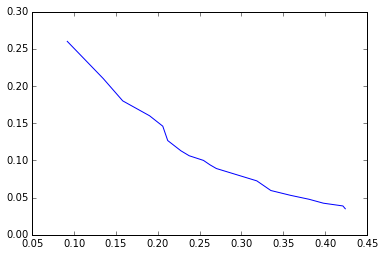

In [470]:
plt.plot(evaluation_results['mean_recall'], evaluation_results['mean_precision'])

#Exercícios

##Exercício 1

In [471]:
artists = ['Kanye West', 'Foo Fighters', 'Taylor Swift', 'Lady GaGa']

In [472]:
for artist in artists :
    print '%s: %s' % (artist, len(song_data[song_data['artist'] == artist]['user_id'].unique()))

Kanye West: 2522
Foo Fighters: 2055
Taylor Swift: 3246
Lady GaGa: 2928


##Exercício 2

In [473]:
artists_popularity = song_data.groupby(key_columns='artist', operations={'total_count': sf.aggregate.SUM('listen_count')})

In [474]:
artists_popularity = artists_popularity.sort('total_count', ascending=False)

In [475]:
print artists_popularity[0]
print artists_popularity[-1]

{'total_count': 43218L, 'artist': 'Kings Of Leon'}
{'total_count': 14L, 'artist': 'William Tabbert'}


##Exercício 3

Do jeito que fiz leva muito tempo para fazer. Deve haver alguma outra forma de calcular isso.

In [500]:
subset_test_users = test_data['user_id'].unique()[0:10000]

In [501]:
recommendations = personalized_model.recommend(subset_test_users, k=1)

recommendations finished on 1000/9948 queries. users per second: 52.0880957378

recommendations finished on 2000/9948 queries. users per second: 56.6037278322

recommendations finished on 3000/9948 queries. users per second: 55.4828750749

recommendations finished on 4000/9948 queries. users per second: 57.0683736673

recommendations finished on 5000/9948 queries. users per second: 50.7849454373

recommendations finished on 6000/9948 queries. users per second: 52.0011399435

recommendations finished on 7000/9948 queries. users per second: 50.3842984738

recommendations finished on 8000/9948 queries. users per second: 45.6816998446

recommendations finished on 9000/9948 queries. users per second: 47.6908590775

Getting recommended items in 194.877904185s.


In [502]:
recommendations_popularity = recommendations.groupby(key_columns='song', operations={'count': sf.aggregate.COUNT()})

In [503]:
recommendations_popularity = recommendations_popularity.sort('count', ascending=False)

In [504]:
print recommendations_popularity[0]

{'count': 452L, 'song': 'Undo - Bj\xc3\xb6rk'}


In [505]:
recommendations_popularity

song,count
Undo - Björk,452
Secrets - OneRepublic,318
Revelry - Kings Of Leon,244
You're The One - DwightYoakam ...,167
Fireflies - CharttraxxKaraoke ...,123
Hey_ Soul Sister - Train,100
Horn Concerto No. 4 in Eflat K495: II. Romance ...,95
Sehr kosmisch - Harmonia,80
OMG - Usher featuringwill.i.am ...,61
The Scientist - Coldplay,48
